In [1]:
import torch
flag = torch.cuda.is_available()
print(flag)

ngpu= 1
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)
print(torch.cuda.get_device_name(0))
print(torch.rand(3,3).cuda())

True
cuda:0
GeForce MX150
tensor([[0.3118, 0.4025, 0.0014],
        [0.8694, 0.3132, 0.8377],
        [0.5908, 0.2846, 0.6952]], device='cuda:0')


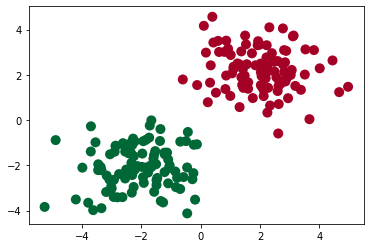

In [2]:
import torch
import matplotlib.pyplot as plt
from torch.autograd import Variable # torch 中 Variable 模块

# 假数据
n_data = torch.ones(100, 2)         # 数据的基本形态
x0 = torch.normal(2*n_data, 1)      # 类型0 x data (tensor), shape=(100, 2)
y0 = torch.zeros(100)               # 类型0 y data (tensor), shape=(100, )
x1 = torch.normal(-2*n_data, 1)     # 类型1 x data (tensor), shape=(100, 1)
y1 = torch.ones(100)                # 类型1 y data (tensor), shape=(100, )

# 注意 x, y 数据的数据形式是一定要像下面一样 (torch.cat 是在合并数据)
x = torch.cat((x0, x1), 0).type(torch.FloatTensor)  # FloatTensor = 32-bit floating
y = torch.cat((y0, y1), ).type(torch.LongTensor)    # LongTensor = 64-bit integer
x,y = Variable(x),Variable(y)

# 画图
plt.scatter(x.data.numpy()[:, 0], x.data.numpy()[:, 1], c=y.data.numpy(), s=100, lw=0, cmap='RdYlGn')
plt.show()

# 建立神經網絡

In [3]:
import torch
import torch.nn.functional as F     # 激励函数都在这

class Net(torch.nn.Module):     # 继承 torch 的 Module
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()     # 继承 __init__ 功能
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # 隐藏层线性输出
        self.out = torch.nn.Linear(n_hidden, n_output)       # 输出层线性输出

    def forward(self, x):
        # 正向传播输入值, 神经网络分析出输出值
        x = F.relu(self.hidden(x))      # 激励函数(隐藏层的线性值)
        x = self.out(x)                 # 输出值, 但是这个不是预测值, 预测值还需要再另外计算
        return x

net = Net(n_feature=2, n_hidden=10, n_output=2) # 几个类别就几个 output

print(net)  # net 的结构

Net(
  (hidden): Linear(in_features=2, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=2, bias=True)
)


# 訓練網絡

D:\Program\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


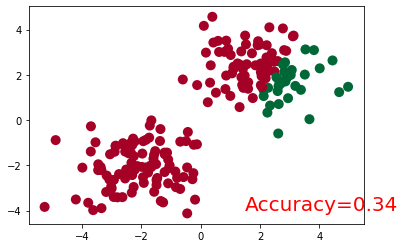

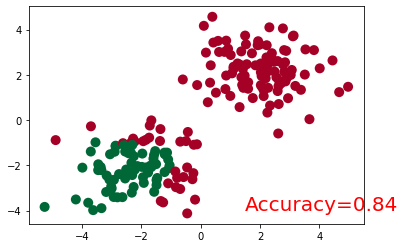

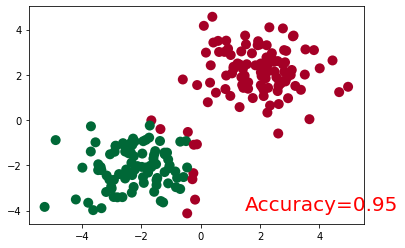

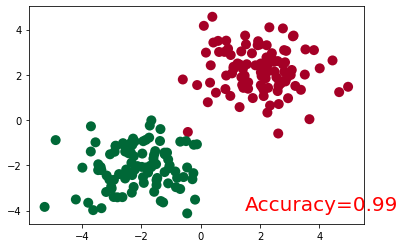

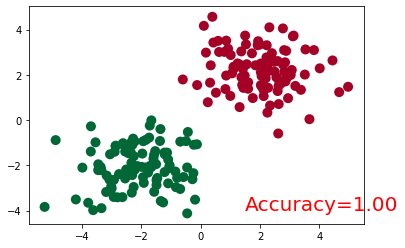

In [4]:
# optimizer 是训练的工具
optimizer = torch.optim.SGD(net.parameters(), lr=0.02)  # 传入 net 的所有参数, 学习率
# 算误差的时候, 注意真实值!不是! one-hot 形式的, 而是1D Tensor, (batch,)
# 但是预测值是2D tensor (batch, n_classes)
loss_func = torch.nn.CrossEntropyLoss()

for t in range(100):
    out = net(x)     # 喂给 net 训练数据 x, 输出分析值

    loss = loss_func(out, y)     # 计算两者的误差

    optimizer.zero_grad()   # 清空上一步的残余更新参数值
    loss.backward()         # 误差反向传播, 计算参数更新值
    optimizer.step()        # 将参数更新值施加到 net 的 parameters 上
    
     # 接着上面来
    if t % 20 == 0:
        plt.cla()
        # 过了一道 softmax 的激励函数后的最大概率才是预测值
        prediction = torch.max(F.softmax(out), 1)[1] ; #print(F.softmax(out)) #機率
        pred_y = prediction.data.numpy().squeeze()
        target_y = y.data.numpy()
        plt.scatter(x.data.numpy()[:, 0], x.data.numpy()[:, 1], c=pred_y, s=100, lw=0, cmap='RdYlGn')
        accuracy = sum(pred_y == target_y)/200.  # 预测中有多少和真实值一样
        plt.text(1.5, -4, 'Accuracy=%.2f' % accuracy, fontdict={'size': 20, 'color':  'red'})
        plt.pause(0.1)

# 保存

In [5]:
import os
if not os.path.exists('classification'): os.makedirs('classification')
torch.save(net, 'classification/net.pkl')  # 保存整个网络
torch.save(net.state_dict(), 'classification/net_params.pkl')   # 只保存网络中的参数 (速度快, 占内存少)

D:\Program\Anaconda3\envs\tensorflow\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# 提取網絡

In [6]:
def restore_net():
    net = torch.load('classification/net.pkl')
    prediction = F.softmax(net(x))
#     print(prediction)
    
restore_net()

D:\Program\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


# 快速搭建法

In [7]:
import torch
import torch.nn.functional as F


# replace following class code with an easy sequential network
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

net1 = Net(1, 10, 1)

# easy and fast way to build your network
net2 = torch.nn.Sequential(
    torch.nn.Linear(1, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 1)
)

In [8]:
net1

Net(
  (hidden): Linear(in_features=1, out_features=10, bias=True)
  (predict): Linear(in_features=10, out_features=1, bias=True)
)

In [9]:
net2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=1, bias=True)
)